In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer


model_path = "/content/drive/MyDrive/arabertv2_sentence_classifier"
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# تحميل tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# دالة للتنبؤ
def predict(text):
    # تحويل النص إلى tokens
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # إرسال النص عبر النموذج للحصول على التنبؤ
    with torch.no_grad():
        logits = model(**inputs).logits

    # تحويل النتائج إلى فئة متوقعة (0 أو 1)
    prediction = torch.argmax(logits, dim=-1).item()

    # تخصيص الفئات: 0 = "اسم" ، 1 = "فعل"
    if prediction == 1:
        return "(فعل-فاعل-مفعول به)فعلية"
    else:
        return "(مبتدأ-خبر)اسمية"

# تجربة النصوص الجديدة
new_text = " ركل اللاعب الكرة  "
prediction = predict(new_text)

print(f"    الجملة: {prediction}")

    الجملة: (فعل-فاعل-مفعول به)فعلية


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch



# دالة للتنبؤ
def predict(text):
    # تحويل النص إلى tokens
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # إرسال النص عبر النموذج للحصول على التنبؤ
    with torch.no_grad():
        logits = model(**inputs).logits

    # تحويل النتائج إلى فئة متوقعة (0 أو 1)
    prediction = torch.argmax(logits, dim=-1).item()

    # تخصيص الفئات: 0 = "اسم" ، 1 = "فعل"
    if prediction == 1:
        return "(فعل-فاعل-مفعول به)فعلية"
    else:
        return "(مبتدأ-خبر)اسمية"

# تجربة النصوص الجديدة
new_text = "  محمد مجتهد  "
prediction = predict(new_text)

print(f"    الجملة: {prediction}")

    الجملة: (مبتدأ-خبر)اسمية


100%|██████████| 63/63 [03:10<00:00,  3.03s/it]


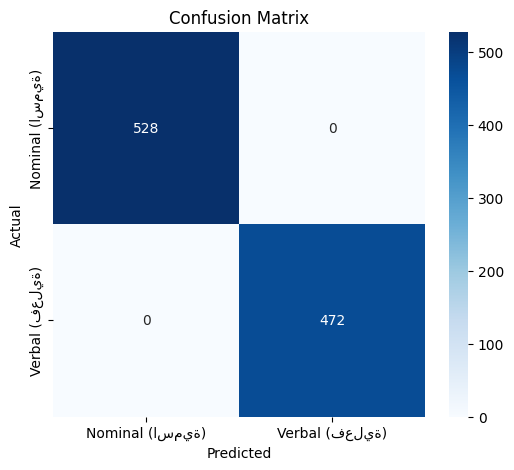

In [ ]:
import torch
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
from tqdm import tqdm

# 1. تحديد الجهاز
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 2. تحميل Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# 3. إعداد Dataset
class ArabicSentenceDataset(Dataset):
    def __init__(self, json_file, tokenizer, max_length=64):
        with open(json_file, 'r', encoding='utf-8') as f:
            self.data = json.load(f)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        encoding = self.tokenizer(item['text'],
                                  padding='max_length',
                                  truncation=True,
                                  max_length=self.max_length,
                                  return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(item['label'])
        }

# 4. تحميل test dataset
test_dataset = ArabicSentenceDataset('test.json', tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=16)

# 5. تشغيل النموذج وجمع النتائج
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 6. رسم Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
labels = ['Nominal (اسمية)', 'Verbal (فعلية)']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
